# Create Denosing Model
This note book will use
- pytorch
- fashion_minst
to create a denosing UNet to be deployed on Alveo U50
To avoid size truncation during the test, we use cifar-10 32x32 instead 

In [83]:
import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


In [84]:
# check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [85]:
# Define constants
BATCH_SIZE = 64
EPOCHS = 20
NOISE_FACTOR = 0.2
LEARNING_RATE = 0.001

In [86]:
# Define transformations
transform = transforms.Compose([transforms.ToTensor()])

In [87]:
from torchvision import datasets, transforms

# 示例的 transform，适用于 CIFAR10
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # CIFAR10 是 RGB 图像
])

trainset = datasets.CIFAR10(root='0_data/', download=True, train=True, transform=transform)
testset = datasets.CIFAR10(root='0_data/', download=True, train=False, transform=transform)

trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True)

In [88]:
import torch.nn as nn
import torch.nn.functional as F

class Denoise(nn.Module):
    def __init__(self):
        super(Denoise, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 8, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        
        # Decoder - 修改为更稳定的结构
        self.decoder = nn.Sequential(
            # 使用上采样+卷积代替转置卷积
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(8, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            
            nn.Conv2d(16, 3, kernel_size=3, padding=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        # 保存原始尺寸
        orig_size = x.size()[2:]
        
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        
        # 确保输出尺寸与输入一致
        if decoded.size()[2:] != orig_size:
            decoded = F.interpolate(decoded, size=orig_size, mode='bilinear', align_corners=False)
        
        return decoded


In [89]:
# Initialize the model, loss function, and optimizer
model = Denoise().float()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [90]:
# Function to add noise to images
def add_noise(images, noise_factor=NOISE_FACTOR):
    noise = noise_factor * torch.randn_like(images)
    noisy_images = images + noise
    noisy_images = torch.clamp(noisy_images, 0., 1.)  # Ensure values stay within [0, 1]
    return noisy_images


In [91]:
def train(model, trainloader, device):
    model.train()
    model.to(device)
    train_loss = 0
    for images, _ in trainloader:
        images = images.to(device)
        noisy_images = add_noise(images).to(device)
        
        optimizer.zero_grad()
        outputs = model(noisy_images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    return train_loss / len(trainloader)

def test(model, testloader, device):
    model.eval()
    model.to(device)
    test_loss = 0
    with torch.no_grad():
        for images, _ in testloader:
            images = images.to(device)
            noisy_images = add_noise(images).to(device)
            outputs = model(noisy_images)
            loss = criterion(outputs, images)
            test_loss += loss.item()
    return test_loss / len(testloader)

In [92]:
# Training loop
# put the model on the device
# model = model.to(device)
for epoch in range(1, EPOCHS + 1):
    train_loss = train(model, trainloader, device)
    test_loss = test(model, testloader, device)
    print(f'Epoch [{epoch}/{EPOCHS}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')


Epoch [1/20], Train Loss: 0.1783, Test Loss: 0.1514
Epoch [2/20], Train Loss: 0.1532, Test Loss: 0.1490
Epoch [3/20], Train Loss: 0.1515, Test Loss: 0.1476
Epoch [4/20], Train Loss: 0.1503, Test Loss: 0.1470
Epoch [5/20], Train Loss: 0.1496, Test Loss: 0.1462
Epoch [6/20], Train Loss: 0.1491, Test Loss: 0.1458
Epoch [7/20], Train Loss: 0.1488, Test Loss: 0.1455
Epoch [8/20], Train Loss: 0.1487, Test Loss: 0.1454
Epoch [9/20], Train Loss: 0.1484, Test Loss: 0.1454
Epoch [10/20], Train Loss: 0.1482, Test Loss: 0.1451
Epoch [11/20], Train Loss: 0.1480, Test Loss: 0.1451
Epoch [12/20], Train Loss: 0.1479, Test Loss: 0.1447
Epoch [13/20], Train Loss: 0.1477, Test Loss: 0.1445
Epoch [14/20], Train Loss: 0.1477, Test Loss: 0.1449
Epoch [15/20], Train Loss: 0.1476, Test Loss: 0.1444
Epoch [16/20], Train Loss: 0.1476, Test Loss: 0.1443
Epoch [17/20], Train Loss: 0.1475, Test Loss: 0.1445
Epoch [18/20], Train Loss: 0.1474, Test Loss: 0.1444
Epoch [19/20], Train Loss: 0.1474, Test Loss: 0.1441
Ep

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.5686275].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.81960785..0.9529412].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.46666664..0.84313726].


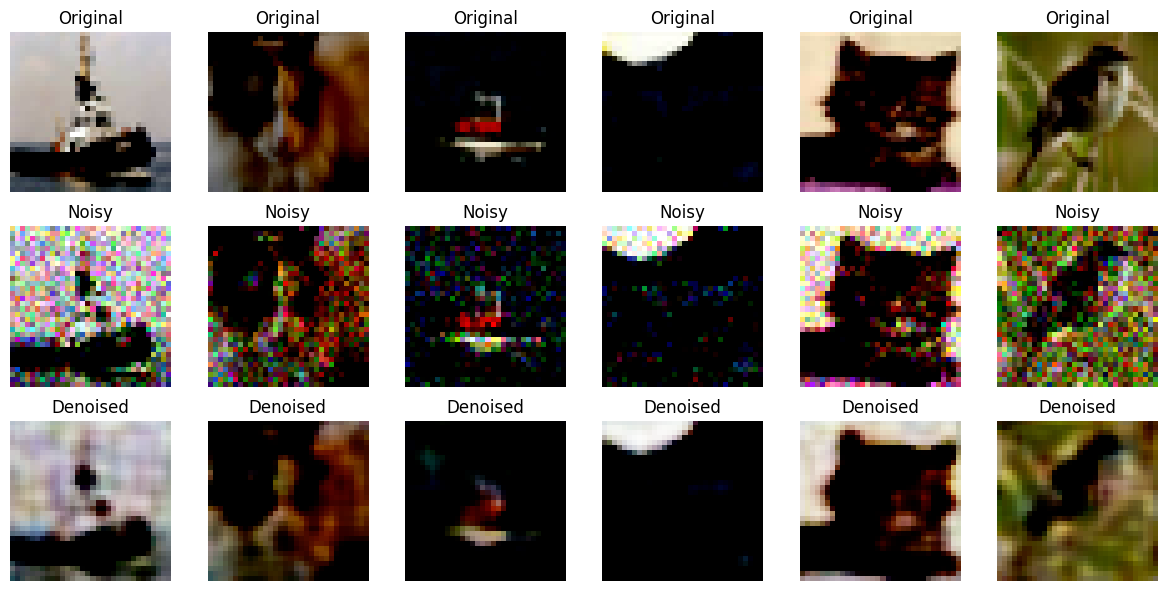

In [93]:
import matplotlib.pyplot as plt
import torch

# model back to CPU for visualization
model = model.to('cpu')

# Assuming dataiter, testloader, add_noise, and model are defined
dataiter = iter(testloader)
images, labels = next(dataiter)
noisy_images = add_noise(images)
outputs = model(noisy_images)

# Plot original, noisy, and denoised images
fig, axes = plt.subplots(3, 6, figsize=(12, 6))
for i in range(6):
    # Transpose images from (3, 32, 32) to (32, 32, 3) for RGB
    # Original images
    orig_img = images[i].permute(1, 2, 0).numpy()  # Change shape to (32, 32, 3)
    axes[0, i].imshow(orig_img)
    axes[0, i].set_title("Original")
    axes[0, i].axis('off')
    
    # Noisy images
    noisy_img = noisy_images[i].permute(1, 2, 0).numpy()  # Change shape to (32, 32, 3)
    axes[1, i].imshow(noisy_img)
    axes[1, i].set_title("Noisy")
    axes[1, i].axis('off')
    
    # Denoised images
    denoised_img = outputs[i].permute(1, 2, 0).detach().numpy()  # Change shape to (32, 32, 3)
    axes[2, i].imshow(denoised_img)
    axes[2, i].set_title("Denoised")
    axes[2, i].axis('off')

plt.tight_layout()
plt.show()

In [94]:
# Save the model to 1_model/
torch.save(model.state_dict(), '1_model/denoise_unet_cifar10_140_f32.pth', _use_new_zipfile_serialization=False )

In [95]:
# Save the onnx model as well
dummy_input = torch.randn(1, 3, 32, 32, dtype=torch.float32)
torch.onnx.export(model, dummy_input, '1_model/denoise_unet_cifar10_140_f32.onnx', 
                  input_names=['input'], output_names=['output'], 
                  dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}})
# Save the model to 1_model/ in ONNX format
print("Model saved to 1_model/denoise_unet_140_f32.pth and 1_model/denoise_unet_140_f32.onnx")

Model saved to 1_model/denoise_unet_140_f32.pth and 1_model/denoise_unet_140_f32.onnx


/tmp/ipykernel_64567/3101413246.py:39: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if decoded.size()[2:] != orig_size:
